<a href="https://colab.research.google.com/github/gurovic/MLCourse/blob/main/195_feature_importances.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Интерпретация: важность признаков (Feature Importances) для бэггинга и бустинга


## 🟢 Зеленый уровень — Базовое понимание

**Что такое «важность признаков»?**  
Когда мы обучили модель, хочется понять, какие признаки (features) были самыми значимыми для предсказаний.  
*Feature importance* — это численная оценка вклада каждого признака в решение модели.

**В бэггинге и бустинге (например, Random Forest, XGBoost, LightGBM)** такие оценки обычно основаны на том,  
насколько часто и сильно признак используется в деревьях для разделения данных.

**Пример с жизнью:**  
Ты выбираешь ноутбук. Для тебя важнее всего цена, чуть меньше — вес, а цвет почти не важен.  
Если модель «думает» так же, то *price* получит высокую важность, *weight* — среднюю, *color* — маленькую.

**Почему это полезно:**
- Можно отсеять ненужные признаки.
- Можно объяснить заказчику, что модель «решает» разумно.
- Можно понять, куда собирать больше данных.


In [1]:
# Пример: Важность признаков в RandomForest (базовый)
from sklearn.datasets import load_breast_cancer
from sklearn.ensemble import RandomForestClassifier
import pandas as pd

# Загружаем данные
data = load_breast_cancer()
X, y = data.data, data.target

# Обучаем модель
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X, y)

# Получаем важности
importances = pd.Series(rf.feature_importances_, index=data.feature_names)

# Выводим топ-5
importances.sort_values(ascending=False).head()


,0
worst area,0.139357
worst concave points,0.132225
mean concave points,0.107046
worst radius,0.082848
worst perimeter,0.080850



**🟢 Упражнения:**
1. Назови 3 ситуации, когда полезно знать важность признаков.
2. Придумай пример признака, который может быть важным в задаче прогноза успеваемости школьников.
3. Выведи топ-10 признаков и построй горизонтальный график важностей.


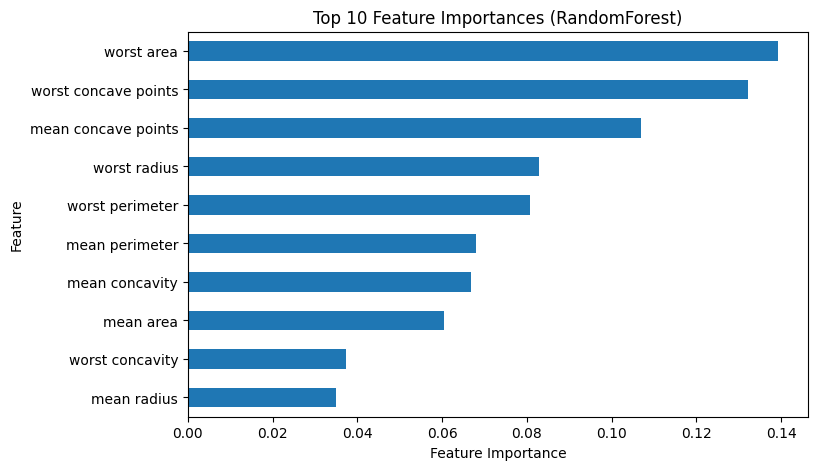

In [2]:
# Построение горизонтального графика важностей
import matplotlib.pyplot as plt

top10 = importances.sort_values(ascending=False).head(10)
plt.figure(figsize=(8,5))
top10.plot(kind='barh')
plt.gca().invert_yaxis()
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title("Top 10 Feature Importances (RandomForest)")
plt.show()



## 🟡 Жёлтый уровень — Чуть глубже

**Как вычисляется важность признаков в деревьях:**
1. **Gini Importance** (или *Mean Decrease in Impurity*):  
   Считаем, насколько уменьшилась «грязь» (impurity) в узле при разбиении по признаку.
2. **Mean Decrease Accuracy**:  
   Перемешиваем значения одного признака в тестовых данных и смотрим, насколько упала точность.

**В бэггинге** (например, Random Forest) важность усредняется по всем деревьям.  
**В бустинге** (например, XGBoost, LightGBM) признаки, которые чаще и раньше встречаются в деревьях, обычно получают большую важность.

**Важное предупреждение:**  
- Если признаки сильно коррелированы, их важности могут «размазаться».
- Метрики важности зависят от типа модели — нельзя напрямую сравнивать значения между алгоритмами.


In [4]:

# Сравнение важностей между RandomForest и XGBoost
from xgboost import XGBClassifier

xgb = XGBClassifier(n_estimators=100, random_state=42, use_label_encoder=False, eval_metric='logloss')
xgb.fit(X, y)

importances_xgb = pd.Series(xgb.feature_importances_, index=data.feature_names)

# Сравниваем топ-5
print("RandomForest top-5:")
print(importances.sort_values(ascending=False).head())

print("XGBoost top-5:")
print(importances_xgb.sort_values(ascending=False).head())


RandomForest top-5:
worst area              0.139357
worst concave points    0.132225
mean concave points     0.107046
worst radius            0.082848
worst perimeter         0.080850
dtype: float64
XGBoost top-5:
worst radius            0.459267
worst perimeter         0.211993
mean concave points     0.097121
worst concave points    0.068946
worst area              0.025039
dtype: float32


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [09:51:31] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



**🟡 Упражнения:**
1. Построй два горизонтальных барчарта для RF и XGBoost на одном графике.
2. Найди признаки, которые у RF в топ-5, но у XGBoost нет.
3. Объясни, почему эти различия могут появляться.



## 🔴 Красный уровень — Для любопытных и амбициозных

**Permutation Importance:**  
Перемешиваем значения признака и измеряем, насколько ухудшается метрика — чем сильнее падение, тем важнее признак.

**Формулы для Gini Importance:**
Если признак `j` участвует в узле `t` с количеством объектов `N_t`, а impurity в нём уменьшается на ΔI,  
то вклад признака в важность:
\[
FI_j = \sum_{\text{nodes t split on j}} \frac{N_t}{N_{\text{total}}} \cdot \Delta I_t
\]


In [5]:
# Пример: Permutation Importance
from sklearn.inspection import permutation_importance

result = permutation_importance(rf, X, y, n_repeats=10, random_state=42)
perm_importances = pd.Series(result.importances_mean, index=data.feature_names)

# Сравнение с Gini Importance
comparison = pd.DataFrame({
    "Gini Importance": importances,
    "Permutation Importance": perm_importances
})

comparison.sort_values("Permutation Importance", ascending=False).head()


,Gini Importance,Permutation Importance
mean texture,0.015225,0.002460
mean concave points,0.107046,0.002460
worst concave points,0.132225,0.001757
worst texture,0.017485,0.001757
radius error,0.014264,0.001582



**🔴 Упражнения:**
1. Построй график сравнения Gini Importance и Permutation Importance для топ-15 признаков.
2. Найди признак, для которого разница между двумя методами максимальна, и объясни почему.
3. Реализуй собственную функцию permutation importance для классификатора sklearn.
